In [20]:
 #importation
import pandas as pd
from fastai.vision.utils import get_image_files #allow to collect images from a repertory and to display it
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import torch
from torchvision import models, transforms
from fastai import *
from fastai.vision import *
import pandas as pd
import matplotlib.pyplot as plt

import keras.backend as K
from keras import layers
from keras.layers import Input, Add, Dense, Dropout, MaxPooling2D, Flatten
from keras.models import Model
from keras import optimizers
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import ResNet50
from keras.applications.resnet50 import preprocess_input
from keras.callbacks import History, ModelCheckpoint, Callback
from sklearn.metrics import roc_auc_score
#Image Preprocessing
from keras.preprocessing.image import ImageDataGenerator


In [31]:
#importation of datasets
train_df = pd.read_csv('train.csv')

In [32]:
train_df.head()

,id,has_cactus
0,0004be2cfeaba1c0361d39e2b000257b.jpg,1
1,000c8a36845c0208e833c79c1bffedd1.jpg,1
2,000d1e9a533f62e55c289303b072733d.jpg,1
3,0011485b40695e9138e92d0b3fb55128.jpg,1
4,0014d7a11e90b62848904c1418fc8cf2.jpg,1


In [33]:
#collect of images

train_images_path = "train/train"
test_images_path = "test/test"

train_images = get_image_files(train_images_path)
test_images = get_image_files(test_images_path)  

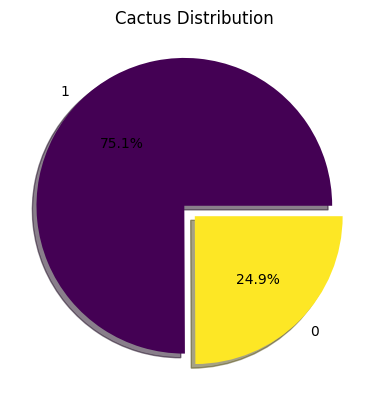

has_cactus
1    13136
0     4364
Name: count, dtype: int64


In [34]:
#data distribution
fig, ax = plt.subplots()
train_df['has_cactus'].value_counts().plot(kind='pie', autopct='%1.1f%%', ax=ax, 
                                        explode=[0.1,0], shadow=True, colormap='viridis')
ax.set_title('Cactus Distribution')
ax.set_ylabel('')  # remove the y label
plt.show()
print(train_df['has_cactus'].value_counts())

#we need to balance the dataset...

In [35]:
datagen = ImageDataGenerator(rescale=1/255.0)
train_dir = "train/"
batch_size = 64
image_size = 32
train_df.has_cactus = train_df.has_cactus.astype(str)
train_generator = datagen.flow_from_dataframe(dataframe=train_df[:14001],directory=train_dir,x_col='id',
                                            y_col='has_cactus',class_mode='binary',batch_size=batch_size,
                                           target_size=(image_size,image_size))


validation_generator = datagen.flow_from_dataframe(dataframe=train_df[14001:],directory=train_dir,x_col='id',
                                                y_col='has_cactus',class_mode='binary',batch_size=batch_size,
                                                target_size=(image_size,image_size))

Found 0 validated image filenames belonging to 0 classes.
Found 0 validated image filenames belonging to 0 classes.


c:\Users\Elliot.bouchy\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\src\preprocessing\image.py:1137: UserWarning: Found 14001 invalid image filename(s) in x_col="id". These filename(s) will be ignored.
  warnings.warn(
c:\Users\Elliot.bouchy\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\src\preprocessing\image.py:1137: UserWarning: Found 3499 invalid image filename(s) in x_col="id". These filename(s) will be ignored.
  warnings.warn(


In [36]:
num_classes=1

def get_model():
    
    # Get base model: ResNet 50 - don't include the last set of layers dense and FC
    base_model = ResNet50(weights='imagenet',include_top=False,input_shape=(32, 32, 3))
    
    # Freeze the layers in base model
    for layer in base_model.layers:
        layer.trainable = True
        
    # Get output from base model
    base_model_output = base_model.output
    
    # Add our layers of Dense and FC at the end
    
    # FC layer and softmax
    last_layers = Flatten()(base_model_output)
    last_layers = Dense(512,activation='relu')(last_layers)
    last_layers = Dense(num_classes,activation='sigmoid',name='fcnew')(last_layers)
    
    model = Model(inputs=base_model.input,outputs=last_layers)
    return model

In [37]:
model = get_model()
optimizer = optimizers.Adam(lr=0.0001)
model.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 38, 38, 3)            0         ['input_3[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 16, 16, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 16, 16, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                        

In [38]:
class Loss(Callback):    
    def on_train_begin(self, logs={}):
        self.losses = []
        logs['val_auc'] = 0
            
    def on_epoch_begin(self, epoch, logs={}):
        return
    
    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs['loss'])
        
        y_p = []
        y_v = []
        for i in range(len(validation_data)):
            x_val, y_val = validation_data[i]
            y_pred = self.model.predict(x_val)
            y_p.append(y_pred)
            y_v.append(y_val)
        y_p = np.concatenate(y_p)
        y_v = np.concatenate(y_v)
        roc_auc = roc_auc_score(y_v, y_p)
        print ('\nVal AUC for epoch{}: {}'.format(epoch, roc_auc))
        logs['val_auc']=roc_auc

In [39]:
epochs = 4
batch_size = 64
loss = Loss()
checkpoint = ModelCheckpoint("best_model.hdf5", monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=True, mode='min', period=1)
history = model.fit_generator(train_data,
                    steps_per_epoch=train_data.n//batch_size,
                    validation_data=validation_data,
                    validation_steps=validation_data.n//batch_size,
                    epochs=epochs,
                    callbacks=[loss,checkpoint])

Epoch 1/4


C:\Users\Elliot.bouchy\AppData\Local\Temp\ipykernel_14408\2813810212.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_data,


InvalidArgumentError: Graph execution error:

Detected at node 'model_2/conv1_conv/BiasAdd' defined at (most recent call last):
    File "c:\Users\Elliot.bouchy\AppData\Local\Programs\Python\Python38\lib\runpy.py", line 192, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\Elliot.bouchy\AppData\Local\Programs\Python\Python38\lib\runpy.py", line 85, in _run_code
      exec(code, run_globals)
    File "C:\Users\Elliot.bouchy\AppData\Roaming\Python\Python38\site-packages\ipykernel_launcher.py", line 18, in <module>
      app.launch_new_instance()
    File "C:\Users\Elliot.bouchy\AppData\Roaming\Python\Python38\site-packages\traitlets\config\application.py", line 1075, in launch_instance
      app.start()
    File "C:\Users\Elliot.bouchy\AppData\Roaming\Python\Python38\site-packages\ipykernel\kernelapp.py", line 739, in start
      self.io_loop.start()
    File "C:\Users\Elliot.bouchy\AppData\Roaming\Python\Python38\site-packages\tornado\platform\asyncio.py", line 205, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\Elliot.bouchy\AppData\Local\Programs\Python\Python38\lib\asyncio\base_events.py", line 563, in run_forever
      self._run_once()
    File "c:\Users\Elliot.bouchy\AppData\Local\Programs\Python\Python38\lib\asyncio\base_events.py", line 1844, in _run_once
      handle._run()
    File "c:\Users\Elliot.bouchy\AppData\Local\Programs\Python\Python38\lib\asyncio\events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\Elliot.bouchy\AppData\Roaming\Python\Python38\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue
      await self.process_one()
    File "C:\Users\Elliot.bouchy\AppData\Roaming\Python\Python38\site-packages\ipykernel\kernelbase.py", line 534, in process_one
      await dispatch(*args)
    File "C:\Users\Elliot.bouchy\AppData\Roaming\Python\Python38\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell
      await result
    File "C:\Users\Elliot.bouchy\AppData\Roaming\Python\Python38\site-packages\ipykernel\ipkernel.py", line 359, in execute_request
      await super().execute_request(stream, ident, parent)
    File "C:\Users\Elliot.bouchy\AppData\Roaming\Python\Python38\site-packages\ipykernel\kernelbase.py", line 778, in execute_request
      reply_content = await reply_content
    File "C:\Users\Elliot.bouchy\AppData\Roaming\Python\Python38\site-packages\ipykernel\ipkernel.py", line 446, in do_execute
      res = shell.run_cell(
    File "C:\Users\Elliot.bouchy\AppData\Roaming\Python\Python38\site-packages\ipykernel\zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\Elliot.bouchy\AppData\Roaming\Python\Python38\site-packages\IPython\core\interactiveshell.py", line 3009, in run_cell
      result = self._run_cell(
    File "C:\Users\Elliot.bouchy\AppData\Roaming\Python\Python38\site-packages\IPython\core\interactiveshell.py", line 3064, in _run_cell
      result = runner(coro)
    File "C:\Users\Elliot.bouchy\AppData\Roaming\Python\Python38\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\Elliot.bouchy\AppData\Roaming\Python\Python38\site-packages\IPython\core\interactiveshell.py", line 3269, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\Elliot.bouchy\AppData\Roaming\Python\Python38\site-packages\IPython\core\interactiveshell.py", line 3448, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\Elliot.bouchy\AppData\Roaming\Python\Python38\site-packages\IPython\core\interactiveshell.py", line 3508, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\Elliot.bouchy\AppData\Local\Temp\ipykernel_14408\2813810212.py", line 5, in <module>
      history = model.fit_generator(train_data,
    File "c:\Users\Elliot.bouchy\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\src\engine\training.py", line 2810, in fit_generator
      return self.fit(
    File "c:\Users\Elliot.bouchy\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Elliot.bouchy\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\src\engine\training.py", line 1742, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\Elliot.bouchy\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\src\engine\training.py", line 1338, in train_function
      return step_function(self, iterator)
    File "c:\Users\Elliot.bouchy\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\src\engine\training.py", line 1322, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\Elliot.bouchy\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\src\engine\training.py", line 1303, in run_step
      outputs = model.train_step(data)
    File "c:\Users\Elliot.bouchy\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\src\engine\training.py", line 1080, in train_step
      y_pred = self(x, training=True)
    File "c:\Users\Elliot.bouchy\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Elliot.bouchy\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\src\engine\training.py", line 569, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Users\Elliot.bouchy\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Elliot.bouchy\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\src\engine\base_layer.py", line 1150, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\Elliot.bouchy\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\src\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Elliot.bouchy\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\src\engine\functional.py", line 512, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "c:\Users\Elliot.bouchy\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\src\engine\functional.py", line 669, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\Users\Elliot.bouchy\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Elliot.bouchy\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\src\engine\base_layer.py", line 1150, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\Elliot.bouchy\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\src\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Elliot.bouchy\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\src\layers\convolutional\base_conv.py", line 311, in call
      outputs = tf.nn.bias_add(
Node: 'model_2/conv1_conv/BiasAdd'
input depth must be evenly divisible by filter depth: 1 vs 3
	 [[{{node model_2/conv1_conv/BiasAdd}}]] [Op:__inference_train_function_57801]

In [41]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title("Accuracy for every epoch")
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.legend(['train','validation'],loc='lower right')
plt.show()

NameError: name 'history' is not defined

In [42]:
val_model = get_model()
val_model.load_weights('best_model.hdf5')

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'best_model.hdf5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)